# Question

In a prison, a warden strikes a deal with the prisoners with the following conditions:-
1. The prisoners are numbered 1 to 100
2. There are 100 slips each which the prisoners have to find out.
3. Every prisoner goes inside a room containing all 100 slips and has 50 chances to pick the slip with their number on it.
4. If they find their number they are good to go.
5. If even one prisoner doesn 't find their number all of them get executed.

The prisoners are allowed to communicate with each other to find the best strategy in order to get them released.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
plt.style.use("ggplot")
!pip install pyvis -q
from pyvis.network import Network
import seaborn
color_pal = seaborn.color_palette(n_colors=50)

In [24]:
def randomize_slips():
    slips = [i for i in range(100)]
    np.random.shuffle(slips)
    prisoners = {}
    for i, j in enumerate(slips):
        prisoners[i] = j
    return prisoners, slips

# Brute Force

Usually we let each prisoner choose 50 random slips.

In [25]:
def prisoner_randomly_picks(prisoner_no, slips, prisoners):
    slips_chosen = np.random.choice(slips, size=50, replace=False)
    for i in slips_chosen:
        if prisoners[i] == prisoner_no:
            return True
    return False

In [26]:
def brute_force(Test_Runs):
    results = {}
    prisoners, slips = randomize_slips()
    for i in range(Test_Runs):
        n_correct = 0
        for j in range(100):
            correct = prisoner_randomly_picks(j, slips, prisoners)
            if correct:
                n_correct += 1
        results[i] = n_correct
    return results

We will try brute force approach with 100 test runs initially and store in the results dictionary. The results are the no. of prisoners who managed to find their slip numbers.

In [27]:
results = brute_force(1000)

The probability of 1 prisoner picking their slip is $\frac{1}{2}$. So the probability that all prisoners pick their number is $(\frac{1}{2})^{100}$ (or) 7.88860905221e-31 (or) 0.0000000000000000000000000000007888

In [28]:
results_random = pd.DataFrame.from_dict(results, orient="index", columns=["no_correct"])

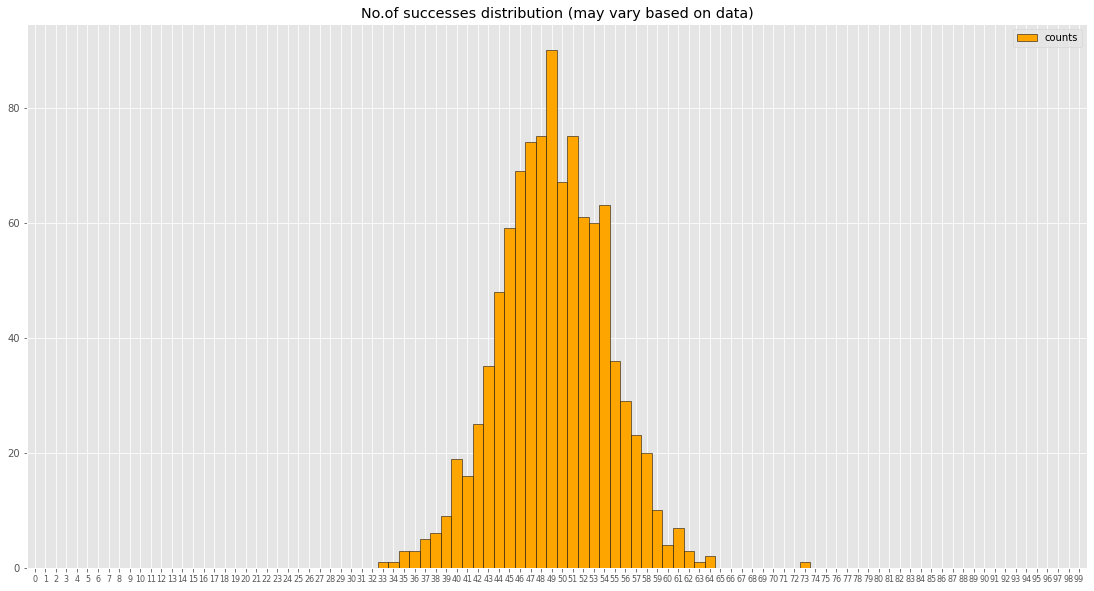

In [29]:
results_agg = pd.DataFrame(index=range(1, 101))
results_agg["counts"] = results_agg.index.map(
    results_random["no_correct"].value_counts().to_dict()
).fillna(0)

ax = results_agg.plot(
    kind="bar",
    figsize=(19, 10),
    color="orange",
    edgecolor="black",
    width=1,
    title="No.of successes distribution (may vary based on data)"
)

ax.set_xticklabels(ax.get_xticks(), rotation=0, size=8)
plt.show()

# Proposed Strategy

Imagine all the slips are indivually put in some kind of box (it would be difficult to manage if all slips were bundled together). If each box has slip numbers randomly distributed, then proposed strategy says that,

* Prisoner will pick the box with their number on it
* Whatever slip number is in that box they would move to the box no containing that slip no
* This process will continue until all 50 turns are exhausted or when the box with the prisoner 's number is found.

In [30]:
def prisoner_loop_picks(prisoner_no, prisoners):
    next_box = prisoner_no
    for i in range(50):
        if prisoners[next_box] == prisoner_no:
            return True
        next_box = prisoners[next_box]
    return False

def oneRun_loop_strat(prisoners, slips):
    n_correct = 0
    for i in range(100):
        correct = prisoner_loop_picks(i, prisoners)
        if correct:
            n_correct += 1
    return n_correct

Lets run this startegy also for 1000 runs and check the results

In [31]:
def loop_strat(Test_Runs):
    results = {}
    for i in range(Test_Runs):
        p, s = randomize_slips()
        results[i] = oneRun_loop_strat(p, s)
    return results
N_results = loop_strat(1000)
results_loop = pd.DataFrame.from_dict(N_results, orient="index", columns=["no_correct"])

In [32]:
for i in set(list(N_results.values())):
    print(f'{i}: {list(N_results.values()).count(i)}')

0: 13
1: 10
2: 8
3: 12
4: 8
5: 11
6: 7
7: 7
8: 12
9: 9
10: 13
11: 7
12: 10
13: 13
14: 9
15: 14
16: 8
17: 15
18: 9
19: 20
20: 17
21: 19
22: 24
23: 12
24: 16
25: 13
26: 18
27: 9
28: 13
29: 14
30: 5
31: 13
32: 12
33: 18
34: 21
35: 15
36: 13
37: 15
38: 18
39: 16
40: 14
41: 22
42: 16
43: 18
44: 19
45: 17
46: 22
47: 19
48: 18
49: 23
100: 296


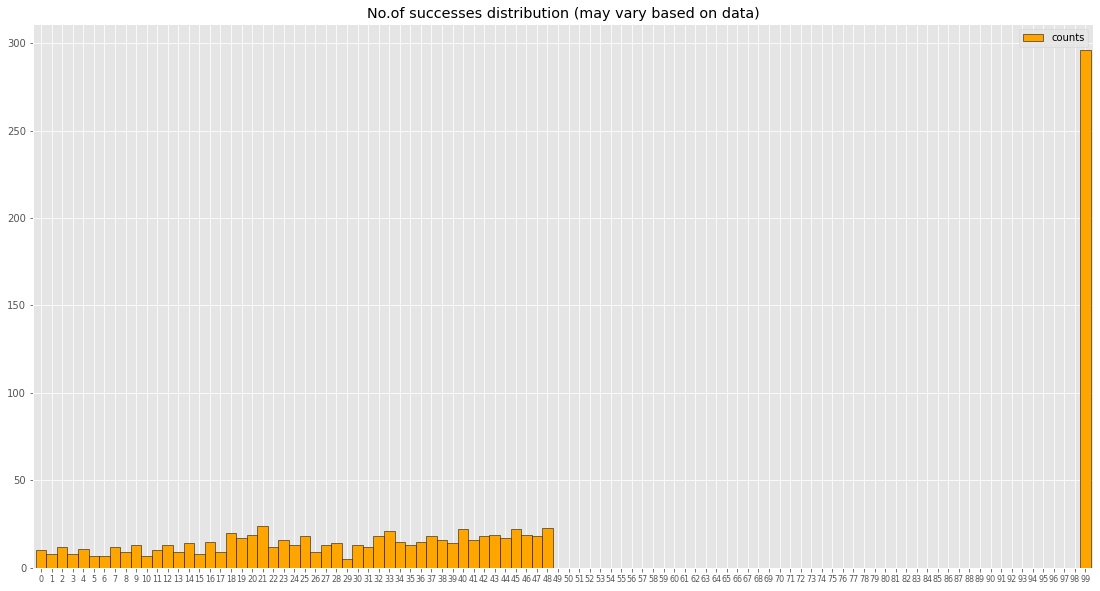

In [33]:
results_agg = pd.DataFrame(index=range(1, 101))
results_agg["counts"] = results_agg.index.map(
    results_loop["no_correct"].value_counts().to_dict()
).fillna(0)

ax = results_agg.plot(
    kind="bar",
    figsize=(19, 10),
    color="orange",
    edgecolor="black",
    width=1,
    title="No.of successes distribution (may vary based on data)"
)

ax.set_xticklabels(ax.get_xticks(), rotation=0, size=8)
plt.show()

# Visualzing a scenario

In [34]:
def create_graph(boxes):
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(100)])
    edges = [(x, y) for x, y in boxes.items()]
    G.add_edges_from(edges, weight=1)
    node_loop = {}
    loops = nx.simple_cycles(G)

    for loop, nodes in enumerate(loops):
        for node in nodes:
            node_loop[node] = loop
    loop_df = pd.DataFrame.from_dict(node_loop, orient="index", columns=["loop"])

    loop_df["color"] = loop_df["loop"].apply(lambda x: color_pal[x])
    loop_df = loop_df.sort_index()
    # Add colors to node
    for node, loop in loop_df["loop"].to_dict().items():
        G.nodes[node]["group"] = str(loop)
        G.nodes[node]["loop_key"] = loop
        G.nodes[node]["label"] = str(node)
    return G, loop_df

In [42]:
boxes = randomize_slips()[0]
G, loop_df = create_graph(boxes)

longest_loop = loop_df["loop"].value_counts().max()
npassed_random = brute_force(1000)
npassed_loop = loop_strat(1000)

print(f"Longest Loop {longest_loop}")
print(f"Random: {sorted(list(npassed_random.values()))}")
print(f"Loop: {sorted(list(npassed_loop.values()))}")

net = Network(notebook=True, height=500, width=1000, directed=True)
net.from_nx(G)
net.show('Interactive_Loops.html')

Longest Loop 81
Random: [36, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47,

# Simluate the Longest Loop

In [37]:
longest_loops = []
for x in range(1000):
    boxes = randomize_slips()[0]
    G, loop_df = create_graph(boxes)
    longest_loop = loop_df["loop"].value_counts().max()
    longest_loops.append(longest_loop)

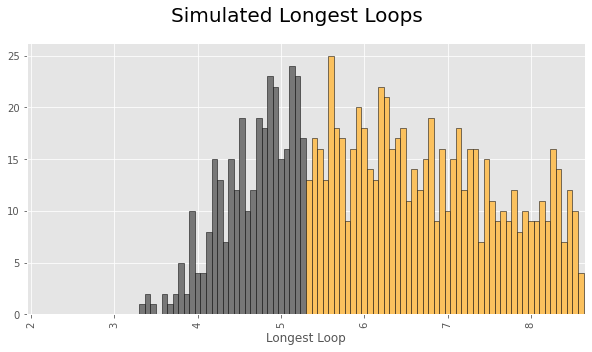

In [38]:
longest_loop_df = pd.DataFrame(index=range(1, 101))
longest_loop_df["count"] = longest_loop_df.index.map(
    pd.Series(longest_loops).value_counts().to_dict()
).fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))

success = longest_loop_df.copy()
success.loc[success.index > 50, "count"] = 0
success.plot(kind="bar", color=color_pal[3], width=1, edgecolor="black", ax=ax)

fail = longest_loop_df.copy()
fail.loc[fail.index <= 50, "count"] = 0
fail.plot(kind="bar", color=color_pal[4], width=1, edgecolor="black", ax=ax)

plt.xlabel("Longest Loop")
fig.suptitle("Simulated Longest Loops", fontsize=20)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.legend().remove()
plt.show()